In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
data = pandas.read_excel('../raw_data/weekly_data_clean.xlsx', engine='openpyxl')
data = data.drop(columns=['Unnamed: 0', 'date_issue'])

In [5]:
dataset = data.values
dataset = dataset.astype('float32')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

88 44


In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [12]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
86/86 - 2s - loss: 0.0210
Epoch 2/100
86/86 - 0s - loss: 0.0093
Epoch 3/100
86/86 - 0s - loss: 0.0081
Epoch 4/100
86/86 - 0s - loss: 0.0080
Epoch 5/100
86/86 - 0s - loss: 0.0081
Epoch 6/100
86/86 - 0s - loss: 0.0081
Epoch 7/100
86/86 - 0s - loss: 0.0081
Epoch 8/100
86/86 - 0s - loss: 0.0080
Epoch 9/100
86/86 - 0s - loss: 0.0081
Epoch 10/100
86/86 - 0s - loss: 0.0081
Epoch 11/100
86/86 - 0s - loss: 0.0081
Epoch 12/100
86/86 - 0s - loss: 0.0080
Epoch 13/100
86/86 - 0s - loss: 0.0080
Epoch 14/100
86/86 - 0s - loss: 0.0082
Epoch 15/100
86/86 - 0s - loss: 0.0081
Epoch 16/100
86/86 - 0s - loss: 0.0081
Epoch 17/100
86/86 - 0s - loss: 0.0080
Epoch 18/100
86/86 - 0s - loss: 0.0080
Epoch 19/100
86/86 - 0s - loss: 0.0080
Epoch 20/100
86/86 - 0s - loss: 0.0081
Epoch 21/100
86/86 - 0s - loss: 0.0081
Epoch 22/100
86/86 - 0s - loss: 0.0081
Epoch 23/100
86/86 - 0s - loss: 0.0081
Epoch 24/100
86/86 - 0s - loss: 0.0080
Epoch 25/100
86/86 - 0s - loss: 0.0081
Epoch 26/100
86/86 - 0s - loss: 0.

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [16]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [17]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 236006.98 RMSE
Test Score: 692138.71 RMSE


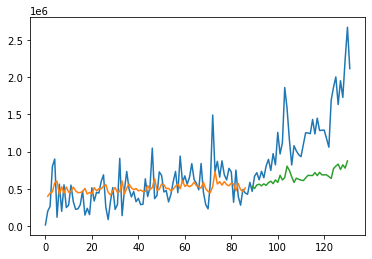

In [18]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()